In [16]:
%load_ext autoreload
%autoreload 2
import torch
import networkx as nx
import matplotlib.pyplot as plt
import copy
import numpy as np

import sys
sys.path.insert(0, "../models/")
sys.path.insert(0, "../lidar/")
from relu_nn import FFReLUNet
from lidar import BatchLidarDataset

torch.set_default_tensor_type(torch.DoubleTensor)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
shape = [2, 16, 16, 16, 1]
model = FFReLUNet(shape)

# Setup data
num_beams = 20
beam_samps = 20
scan_dist = 0.2
num_scans = 300
img_dir = "../data/32_b.png"
bs = 1000 # number of forward passes per gradient compute

train_set = BatchLidarDataset(img_dir, num_beams, scan_dist, beam_samps, num_scans)
val_set = BatchLidarDataset(img_dir, num_beams, scan_dist, beam_samps, 60)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=bs)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=bs)

loss = torch.nn.MSELoss()

lr = 0.005
epochs = 5

opt = torch.optim.AdamW(model.parameters(), lr=lr)

for epoch in range(epochs):
    for i, batch in enumerate(train_loader):
        opt.zero_grad()
        poses = batch["position"]
        dens = batch["density"]

        pred_dens = model.forward(poses)
        l = loss(dens, pred_dens)
        l.backward()
        opt.step()
    
    val_loss = 0.0
    for i, batch in enumerate(val_loader):
        with torch.no_grad():
            pd = model.forward(batch["position"])
            l = loss(batch["density"], pd)
            val_loss += l.data.detach()
    print(val_loss)


tensor(3.9904)
tensor(4.1065)
tensor(3.2532)
tensor(3.2930)
tensor(3.6147)


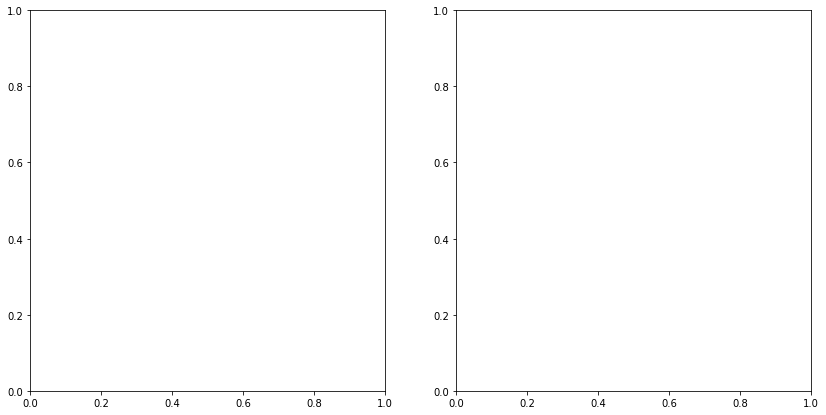

In [34]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
X, Y = np.meshgrid(train_set.lidar.xs, train_set.lidar.ys)
xlocs = X[::8, ::8].reshape(-1, 1).shape
ylocs = Y[::8, ::8].reshape(-1, 1).shape
val_poses = np.hstack((xlocs, ylocs))
